In [8]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter  

 
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV

import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing

In [9]:
#Datos de Diabetes
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')

#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns


#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)

In [10]:
#split

from sklearn.model_selection import train_test_split
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Balanceo con RandomOverSample

os =  RandomOverSampler()
X_train_res_RandOvSamp, y_train_res_RandOvSamp = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_RandOvSamp)))

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})


In [6]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    #print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [5]:
# Perceptron multicapa para los datos desbalanceados
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20,20)],
    'alpha': np.logspace(-3, 3, 7), ##penalizacion de los pesos
    'learning_rate_init': [0.001, 0.01, 0.1], #paso de aprendizaje
}

grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 1000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
42,0.100,"(10, 10)",0.010,0.293833,0.028986,0.294777,0.031094
2,0.001,"(20, 20, 20)",0.010,0.291424,0.004046,0.292942,0.004997
35,0.100,10,0.100,0.290103,0.006546,0.286691,0.007057
30,0.010,10,10.000,0.289379,0.003325,0.288487,0.008142
14,0.100,10,0.010,0.289292,0.001982,0.289422,0.006422
34,0.100,"(10, 10)",10.000,0.288577,0.002928,0.289845,0.003549
32,0.010,"(20, 20, 20)",0.001,0.288100,0.006749,0.289840,0.009870
9,0.010,"(10, 10)",0.010,0.287986,0.004599,0.288725,0.002940
0,0.001,"(20, 20, 20)",0.100,0.287964,0.009322,0.289025,0.006125
47,0.001,"(20, 20, 20)",100.000,0.287473,0.004656,0.287565,0.008122


In [6]:
#GUardar


with open("NN_unbalanced.pkl", 'wb') as file:
    pickle.dump(grid.best_estimator_, file)

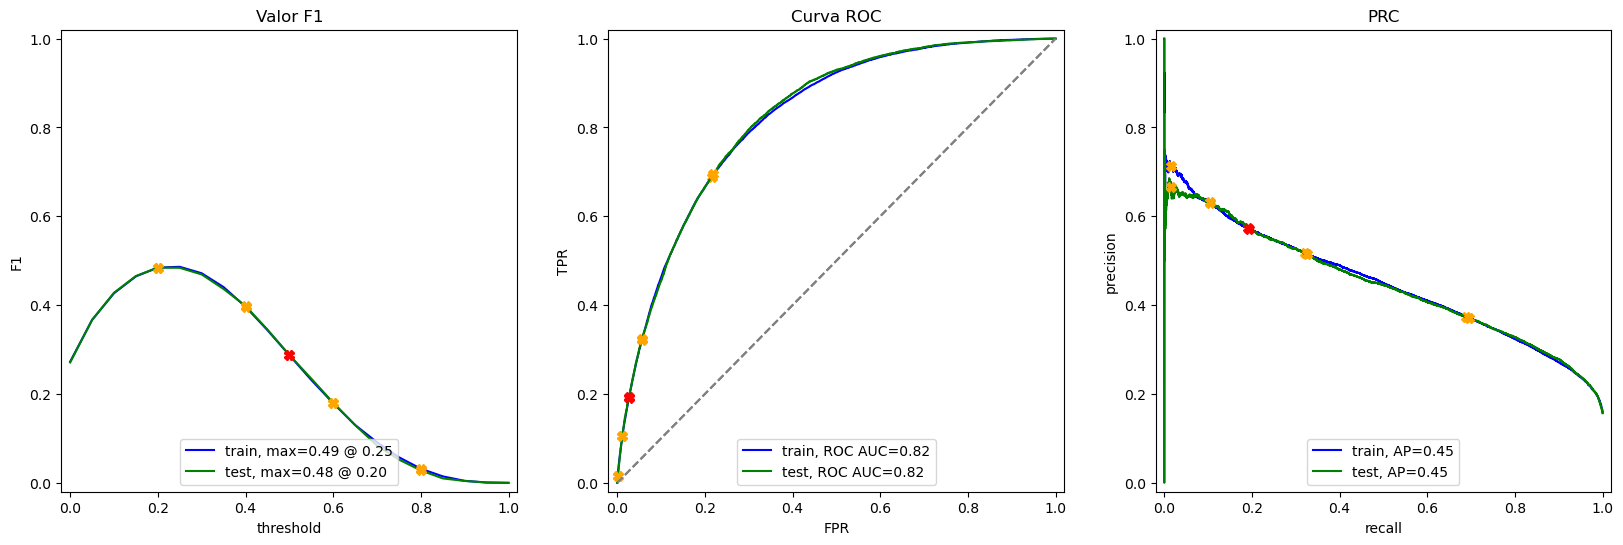

In [7]:
with open("NN_unbalanced.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig = evaluate_model(model, X_train, y_train, X_test, y_test)

df_metrics.to_csv('metrics_NN_unbalanced.csv')

with open('fig_NN_unbalanced.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [8]:
# Perceptron multicapa para los datos balanceados con RandomOverSampler
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20,20)],
    'alpha': np.logspace(-3, 3, 7), ##penalizacion de los pesos
    'learning_rate_init': [0.001, 0.01, 0.1], #paso de aprendizaje
}

grid_NN_RandOvSampler = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 1000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid_NN_RandOvSampler.fit(X = X_train_res_RandOvSamp, y = y_train_res_RandOvSamp)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid_NN_RandOvSampler.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
23,0.100,"(20, 20, 20)",100.000,0.758505,0.001289,0.758566,0.000688
27,0.010,"(20, 20, 20)",100.000,0.758201,0.000873,0.758615,0.000790
47,0.001,"(20, 20, 20)",100.000,0.757434,0.000783,0.758085,0.000283
21,0.100,"(20, 20, 20)",10.000,0.757305,0.001531,0.757913,0.001209
19,0.100,"(20, 20, 20)",0.001,0.757072,0.000731,0.757490,0.001614
32,0.010,"(20, 20, 20)",0.001,0.757021,0.000764,0.757253,0.000250
37,0.001,"(10, 10)",0.001,0.756935,0.001306,0.756961,0.001135
45,0.100,"(10, 10)",100.000,0.756790,0.000479,0.756833,0.000057
4,0.010,"(20, 20, 20)",10.000,0.756744,0.000157,0.757530,0.000561
10,0.100,"(20, 20, 20)",0.100,0.756667,0.000728,0.756280,0.000870


In [9]:
#GUardar


with open("NN_RandOvSampler.pkl", 'wb') as file:
    pickle.dump(grid_NN_RandOvSampler.best_estimator_, file)

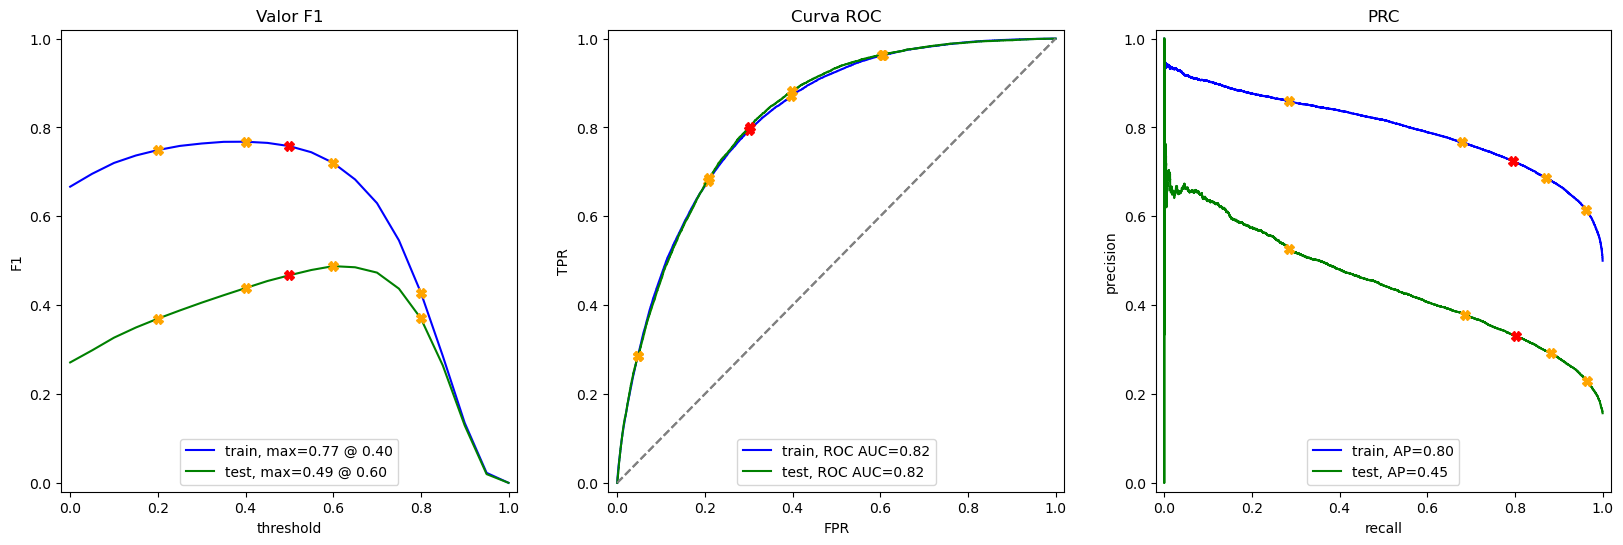

In [10]:
with open("NN_RandOvSampler.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train_res_RandOvSamp, y_train_res_RandOvSamp, X_test, y_test)

df_metrics.to_csv('metrics_NN_RandOvSampler.csv')

with open('fig_NN_RandOvSampler.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [12]:
X_train_res_RandOvSamp_best4= X_train_res_RandOvSamp[['bmi', 'age', 'income', 'genHlth']]
X_test_RandOvSamp_best4 =X_test[['bmi', 'age', 'income', 'genHlth']]

# Perceptron multicapa para los datos balanceados con RandomOverSampler y best4
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20,20)],
    'alpha': np.logspace(-3, 3, 7), ##penalizacion de los pesos
    'learning_rate_init': [0.001, 0.01, 0.1], #paso de aprendizaje
}

grid_NN_RandOvSampler_best4 = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 1000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid_NN_RandOvSampler_best4.fit(X = X_train_res_RandOvSamp_best4, y = y_train_res_RandOvSamp)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid_NN_RandOvSampler_best4.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)


/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
44,0.010,"(20, 20, 20)",0.100,0.739800,0.000435,0.739755,0.000748
31,0.001,"(10, 10)",100.000,0.739783,0.000714,0.739847,0.000381
47,0.001,"(20, 20, 20)",100.000,0.739512,0.000710,0.739596,0.000976
23,0.100,"(20, 20, 20)",100.000,0.739475,0.000837,0.739873,0.000793
27,0.010,"(20, 20, 20)",100.000,0.739335,0.000886,0.739500,0.000371
32,0.010,"(20, 20, 20)",0.001,0.739256,0.000752,0.739329,0.000694
42,0.100,"(10, 10)",0.010,0.739148,0.000494,0.739245,0.000587
45,0.100,"(10, 10)",100.000,0.739077,0.000443,0.739389,0.000882
3,0.010,"(10, 10)",1.000,0.738610,0.000769,0.738636,0.001565
2,0.001,"(20, 20, 20)",0.010,0.738563,0.000528,0.738971,0.000525


In [19]:
#GUardar


with open("NN_RandOvSampler_best4.pkl", 'wb') as file:
    pickle.dump(grid_NN_RandOvSampler_best4.best_estimator_, file)

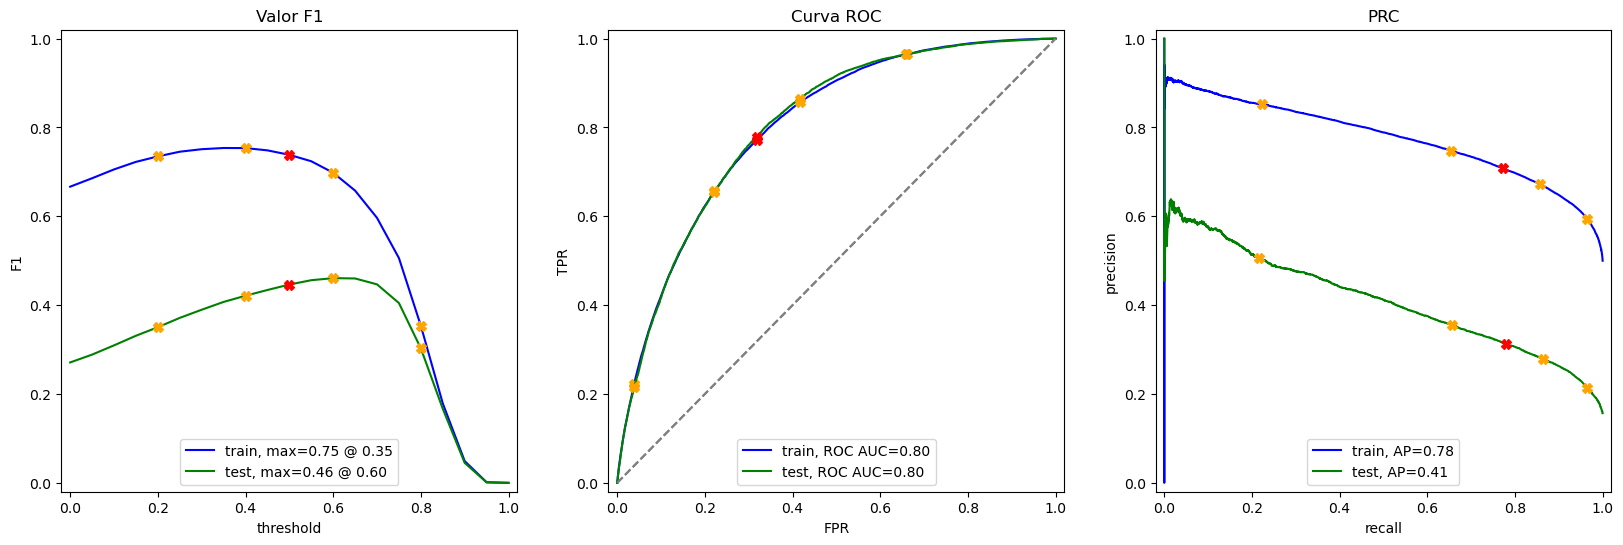

In [12]:
X_train_res_RandOvSamp_best4= X_train_res_RandOvSamp[['bmi', 'age', 'income', 'genHlth']]
X_test_RandOvSamp_best4 =X_test[['bmi', 'age', 'income', 'genHlth']]

with open("NN_RandOvSampler_best4.pkl", 'rb') as file:  
    model = pickle.load(file)

df_metrics, fig =evaluate_model(model, X_train_res_RandOvSamp_best4, y_train_res_RandOvSamp, X_test_RandOvSamp_best4, y_test)

df_metrics.to_csv('metrics_NN_RandOvSampler_best4.csv')

with open('fig_NN_RandOvSampler_best4.pkl', 'wb') as f:
    pickle.dump(fig, f)